In [75]:
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from sklearn.model_selection import train_test_split
from string import punctuation

In [3]:
quora = pd.read_csv('quora.csv')

### 1. Конкатенация эмбеддингов

In [4]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [9]:
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [10]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 40:
        filtered_vocab.add(word)

In [12]:
len(filtered_vocab)

15947

In [13]:
word2id = {'UNK':1, 'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [17]:
id2word = {i:word for word, i in word2id.items()}

In [19]:
X = []

for text in quora.question_text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [25]:
MAX_LEN = max(len(x) for x in X)

In [26]:
MAX_LEN

134

In [29]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [30]:
X.shape

(1306122, 134)

In [31]:
y = quora.target.values

In [34]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=64)

In [35]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

In [36]:
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [37]:
concat = tf.keras.layers.Flatten()(embeddings)

In [38]:
dense = tf.keras.layers.Dense(64, activation='relu')(concat)

In [39]:
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

In [40]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [49]:
model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [50]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=10000,
         epochs=10)

Train on 1240815 samples, validate on 65307 samples
Epoch 1/10
1240815/1240815 [==============================] - 100s 81us/sample - loss: 0.0330 - root_mean_squared_error: 0.1818 - val_loss: 0.0344 - val_root_mean_squared_error: 0.1854
Epoch 2/10
1240815/1240815 [==============================] - 92s 74us/sample - loss: 0.0326 - root_mean_squared_error: 0.1804 - val_loss: 0.0341 - val_root_mean_squared_error: 0.1848
Epoch 3/10
1240815/1240815 [==============================] - 81s 65us/sample - loss: 0.0321 - root_mean_squared_error: 0.1792 - val_loss: 0.0340 - val_root_mean_squared_error: 0.1843
Epoch 4/10
1240815/1240815 [==============================] - 82s 66us/sample - loss: 0.0317 - root_mean_squared_error: 0.1781 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1839
Epoch 5/10
1240815/1240815 [==============================] - 86s 69us/sample - loss: 0.0313 - root_mean_squared_error: 0.1770 - val_loss: 0.0338 - val_root_mean_squared_error: 0.1837
Epoch 6/10
1240815/1240815 

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


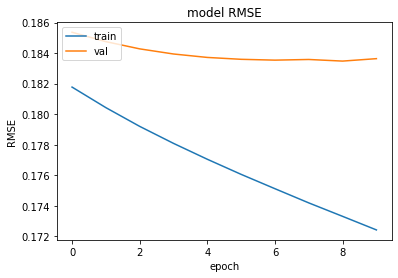

In [52]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Видно, что на валидационной выборке, в отличие от тренировочной, качество практически не растёт. 

### 2. Усреднение эмбеддингов

In [53]:
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

In [54]:
dense = tf.keras.layers.Dense(64, activation='relu')(mean)

In [55]:
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

In [56]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [58]:
model.compile(optimizer=optimizer, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [59]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=10000,
         epochs=10)

Train on 1240815 samples, validate on 65307 samples
Epoch 1/10
1240815/1240815 [==============================] - 51s 41us/sample - loss: 0.2177 - root_mean_squared_error: 0.4665 - val_loss: 0.1890 - val_root_mean_squared_error: 0.4347
Epoch 2/10
1240815/1240815 [==============================] - 54s 44us/sample - loss: 0.1585 - root_mean_squared_error: 0.3981 - val_loss: 0.1276 - val_root_mean_squared_error: 0.3572
Epoch 3/10
1240815/1240815 [==============================] - 72s 58us/sample - loss: 0.1038 - root_mean_squared_error: 0.3222 - val_loss: 0.0844 - val_root_mean_squared_error: 0.2905
Epoch 4/10
1240815/1240815 [==============================] - 68s 55us/sample - loss: 0.0742 - root_mean_squared_error: 0.2723 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2583
Epoch 5/10
1240815/1240815 [==============================] - 62s 50us/sample - loss: 0.0632 - root_mean_squared_error: 0.2515 - val_loss: 0.0607 - val_root_mean_squared_error: 0.2463
Epoch 6/10
1240815/1240815 [

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


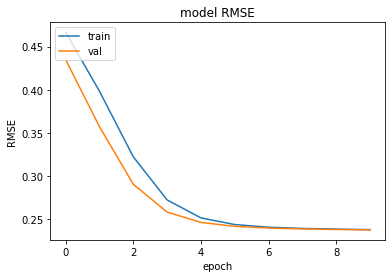

In [60]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Изначальная среднеквадратичная ошибка в этом случае значительно больше, чем в первом варианте, однако и улучшение на обоих выборках драматичнее.

### 3. Сложение эмбеддингов

In [62]:
summed = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x,  axis=1))(embeddings)

In [63]:
dense = tf.keras.layers.Dense(64, activation='relu')(summed)

In [64]:
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

In [65]:
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

In [66]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [67]:
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [68]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=10000,
         epochs=10)

Train on 1240815 samples, validate on 65307 samples
Epoch 1/10
1240815/1240815 [==============================] - 77s 62us/sample - loss: 0.0563 - root_mean_squared_error: 0.2373 - val_loss: 0.0561 - val_root_mean_squared_error: 0.2368
Epoch 2/10
1240815/1240815 [==============================] - 66s 53us/sample - loss: 0.0559 - root_mean_squared_error: 0.2364 - val_loss: 0.0556 - val_root_mean_squared_error: 0.2357
Epoch 3/10
1240815/1240815 [==============================] - 71s 57us/sample - loss: 0.0552 - root_mean_squared_error: 0.2350 - val_loss: 0.0548 - val_root_mean_squared_error: 0.2340
Epoch 4/10
1240815/1240815 [==============================] - 69s 56us/sample - loss: 0.0542 - root_mean_squared_error: 0.2329 - val_loss: 0.0535 - val_root_mean_squared_error: 0.2313
Epoch 5/10
1240815/1240815 [==============================] - 61s 49us/sample - loss: 0.0526 - root_mean_squared_error: 0.2294 - val_loss: 0.0516 - val_root_mean_squared_error: 0.2271
Epoch 6/10
1240815/1240815 [

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


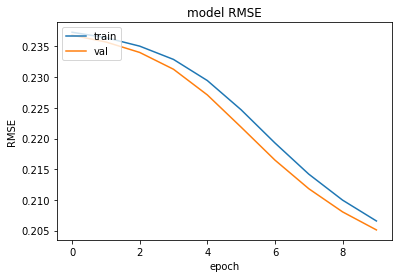

In [69]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

В этом случае качество выборок улучшается почти параллельно. Если ориентироваться на величину разброса, этот вариант лучше других, однако среднеквадратичная ошибка здесь выше, чем в первом из вариантов.

### 4. Использование предобученных эмбеддингов

In [71]:
texts = quora.question_text.apply(preprocess).tolist()

In [72]:
%%time
ft = gensim.models.FastText(texts, size=100)

CPU times: user 9min 50s, sys: 10.3 s, total: 10min
Wall time: 3min 58s


In [73]:
w2v = gensim.models.Word2Vec(texts, size=100)

In [77]:
ft_weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD':
        continue
    
    if word == 'UNK':
        ft_weights[i] = ft['colorlessgreenideas']
    
    try:
        ft_weights[i] = ft[word]
    
    except KeyError:
        ft_weights[i] = ft['sleepfuriously']

/Users/macbookpro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/Users/macbookpro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


In [79]:
w2v_weights = np.zeros((len(word2id), 100))

for word, i in word2id.items():
    if word == 'PAD' or word == 'UNK':
        continue
            
    try:
        w2v_weights[i] = w2v[word] 
    
    except KeyError:
        continue

/Users/macbookpro/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [82]:
ft_embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                      weights=[ft_weights])(inputs)

In [83]:
w2v_embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100, trainable=False,
                                      weights=[w2v_weights])(inputs)

In [84]:
mean = tf.keras.layers.Average()([ft_embeddings, w2v_embeddings]) #усреднение

In [91]:
flat = tf.keras.layers.Flatten()(mean)

In [92]:
dense = tf.keras.layers.Dense(64, activation='relu')(flat)

In [93]:
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

In [94]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [95]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [96]:
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [97]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
         epochs=10)

Train on 1240815 samples, validate on 65307 samples
Epoch 1/10
1240815/1240815 [==============================] - 93s 75us/sample - loss: 0.0588 - root_mean_squared_error: 0.2425 - val_loss: 0.0447 - val_root_mean_squared_error: 0.2115
Epoch 2/10
1240815/1240815 [==============================] - 86s 69us/sample - loss: 0.0427 - root_mean_squared_error: 0.2067 - val_loss: 0.0417 - val_root_mean_squared_error: 0.2041
Epoch 3/10
1240815/1240815 [==============================] - 87s 70us/sample - loss: 0.0404 - root_mean_squared_error: 0.2009 - val_loss: 0.0406 - val_root_mean_squared_error: 0.2015
Epoch 4/10
1240815/1240815 [==============================] - 87s 70us/sample - loss: 0.0391 - root_mean_squared_error: 0.1978 - val_loss: 0.0400 - val_root_mean_squared_error: 0.2000
Epoch 5/10
1240815/1240815 [==============================] - 85s 68us/sample - loss: 0.0382 - root_mean_squared_error: 0.1955 - val_loss: 0.0397 - val_root_mean_squared_error: 0.1992
Epoch 6/10
1240815/1240815 [

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


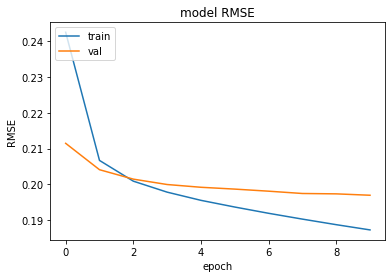

In [98]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [99]:
concat = tf.keras.layers.Concatenate()([ft_embeddings, w2v_embeddings])

In [100]:
flat = tf.keras.layers.Flatten()(concat)

In [101]:
dense = tf.keras.layers.Dense(64, activation='relu')(flat)

In [102]:
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)

In [103]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [104]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [105]:
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [106]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
         epochs=10)

Train on 1240815 samples, validate on 65307 samples
Epoch 1/10
1240815/1240815 [==============================] - 147s 119us/sample - loss: 0.0469 - root_mean_squared_error: 0.2165 - val_loss: 0.0405 - val_root_mean_squared_error: 0.2011
Epoch 2/10
1240815/1240815 [==============================] - 146s 117us/sample - loss: 0.0387 - root_mean_squared_error: 0.1968 - val_loss: 0.0389 - val_root_mean_squared_error: 0.1972
Epoch 3/10
1240815/1240815 [==============================] - 163s 132us/sample - loss: 0.0367 - root_mean_squared_error: 0.1917 - val_loss: 0.0383 - val_root_mean_squared_error: 0.1958
Epoch 4/10
1240815/1240815 [==============================] - 166s 134us/sample - loss: 0.0353 - root_mean_squared_error: 0.1878 - val_loss: 0.0380 - val_root_mean_squared_error: 0.1950
Epoch 5/10
1240815/1240815 [==============================] - 160s 129us/sample - loss: 0.0340 - root_mean_squared_error: 0.1844 - val_loss: 0.0379 - val_root_mean_squared_error: 0.1948
Epoch 6/10
1240815

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


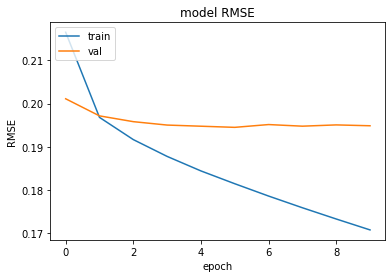

In [107]:
print(model.history.history.keys())
plt.plot(model.history.history['root_mean_squared_error'])
plt.plot(model.history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()